In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Attention, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [2]:
import pandas as pd

# Load the data from the CSV file
data = pd.read_csv("all_daily_max_temp.csv")  # Replace with your actual file path

# Define the features and target column
features = ['elevation', 'relh', 'drct', 'sknt', 'alti', 'vsby', 'dewpoint_c', 'feel_c']
target = 'temp_c'

# Drop unnecessary columns
data = data.drop(columns=['Unnamed: 0', 'is_hot_day'])

# Display the first few rows of the dataset to check
print(data.head())


   elevation   relh   drct  sknt   alti  vsby  temp_c  dewpoint_c     feel_c
0         74  41.42  200.0   4.0  30.06  6.21    25.0        11.0  25.000000
1         74  33.85  230.0  11.0  30.00  1.86    25.0         8.0  24.438889
2         74  53.03  280.0   4.0  30.03  6.21    22.0        12.0  22.000000
3         74  59.97  280.0   5.0  30.09  6.21    20.0        12.0  20.000000
4         74  49.37   40.0  11.0  30.09  6.21    21.0        10.0  21.000000


In [3]:
import numpy as np

# Alternative function to create sequences using sliding windows
def create_sequences_alternative(data, target_col, window_size, prediction_horizon):
    X, y = [], []
    
    # Iterate over the dataset using a sliding window
    for i in range(len(data) - window_size - prediction_horizon + 1):
        # Extract the feature values for the past 'window_size' time steps
        X_seq = data.iloc[i:i + window_size][features].values
        
        # Extract the target values for the next 'prediction_horizon' time steps
        y_seq = data.iloc[i + window_size:i + window_size + prediction_horizon][target_col].values
        
        # Append the sequences to the list
        X.append(X_seq)
        y.append(y_seq)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y

# Parameters
window_size = 9  # Number of timesteps to look at for each sequence
prediction_horizon = 3  # Predict the next 3 days

# Create input-output pairs using the alternative method
X,y= create_sequences_alternative(data, target, window_size, prediction_horizon)

# Display the shapes of the data to check
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"X train ,test shape: {X_train.shape, X_test.shape}")
print(f"y train ,test shape: {y_train.shape, y_test.shape}")


X shape: (5396, 9, 8)
y shape: (5396, 3)
X train ,test shape: ((4316, 9, 8), (1080, 9, 8))
y train ,test shape: ((4316, 3), (1080, 3))


In [4]:
# Updated model architecture
def build_woa_cnn_att_lstm(input_shape, output_size):
    inputs = Input(shape=input_shape)

    # CNN Layer
    x = Conv1D(filters=20, kernel_size=16, activation='relu', padding='same')(inputs)

    # LSTM Layer
    lstm_out = LSTM(units=64, return_sequences=True)(x)

    # Attention Mechanism
    attention = Attention()([lstm_out, lstm_out])
    attention_out = Flatten()(attention)

    # Fully Connected Layer
    dense = Dense(64, activation='relu')(attention_out)
    dense = Dropout(0.2)(dense)

    # Output Layer for multi-day prediction
    outputs = Dense(output_size)(dense)

    # Compile Model
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0082), loss='mse', metrics=['mae'])
    return model

In [5]:
# Build the model
model = build_woa_cnn_att_lstm(input_shape=(window_size, len(features)), output_size=prediction_horizon)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=150, 
                    batch_size=32, 
                    validation_data=(X_test, y_test))

Epoch 1/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 139.3876 - mae: 8.3453 - val_loss: 11.0476 - val_mae: 2.5803
Epoch 2/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 22.3434 - mae: 3.7443 - val_loss: 11.1111 - val_mae: 2.6102
Epoch 3/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 24.1074 - mae: 3.8461 - val_loss: 9.5043 - val_mae: 2.2898
Epoch 4/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 20.7676 - mae: 3.5572 - val_loss: 9.6654 - val_mae: 2.3497
Epoch 5/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 20.3672 - mae: 3.5126 - val_loss: 15.0371 - val_mae: 3.1135
Epoch 6/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 21.4895 - mae: 3.6367 - val_loss: 13.8985 - val_mae: 3.0444
Epoch 7/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 19.6212 - mae: 3.4608 - val_loss: 9.3350 - val_mae: 2.3050
Epoch 8/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 20.6861 - mae: 3.5827 - val_loss: 10.3858 - val_mae: 2.4885
Epoch 9/150
135/135 ━━━━━━━━━━━━━━

In [6]:
# Predict the next 3 days' temperature
next_3_days = model.predict(X_test[-1].reshape(1, window_size, len(features)))
print(f"Predicted Next 3 Days Temperatures: {next_3_days}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Predicted Next 3 Days Temperatures: [[31.303509 31.533176 30.843792]]


In [7]:
# Evaluate the model on training data
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)

# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

# Print the results
print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


Train Loss: 11.5765, Train MAE: 2.5853
Test Loss: 10.5458, Test MAE: 2.5283


In [8]:
# Compute R² for multi-day predictions
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R²: 0.7690805957561725


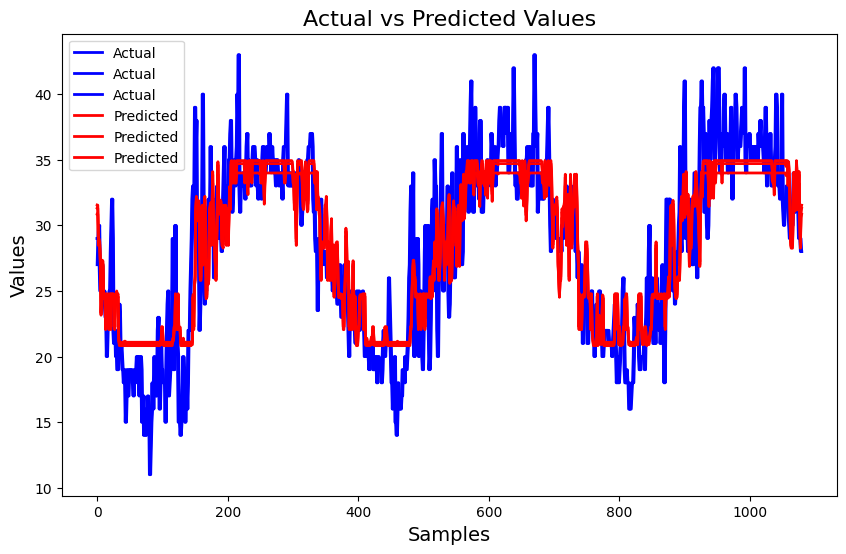

In [9]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined
plt.figure(figsize=(10, 6))

# Plot the actual values
plt.plot(y_test, label='Actual', color='blue', linewidth=2)

# Plot the predicted values
plt.plot(y_pred, label='Predicted', color='red', linewidth=2)

# Adding title and labels
plt.title('Actual vs Predicted Values', fontsize=16)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Values', fontsize=14)

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [10]:
# Function to build a classical LSTM model
def build_classical_lstm(input_shape, output_size):
    inputs = Input(shape=input_shape)

    # LSTM Layer
    lstm_out = LSTM(units=64, return_sequences=False)(inputs)

    # Fully Connected Layer
    dense = Dense(64, activation='relu')(lstm_out)
    dense = Dropout(0.2)(dense)

    # Output Layer for multi-day prediction
    outputs = Dense(output_size)(dense)

    # Compile Model
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0082), loss='mse', metrics=['mae'])
    return model

In [11]:
# Build the classical LSTM model
classical_lstm_model = build_classical_lstm(input_shape=(window_size, len(features)), output_size=prediction_horizon)

# Train the classical LSTM model
classical_history = classical_lstm_model.fit(X_train, y_train, 
                                             epochs=150, 
                                             batch_size=32, 
                                             validation_data=(X_test, y_test))

Epoch 1/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 254.2654 - mae: 12.2756 - val_loss: 36.5121 - val_mae: 5.1204
Epoch 2/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.3542 - mae: 5.2088 - val_loss: 13.7703 - val_mae: 2.9049
Epoch 3/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.3688 - mae: 3.5221 - val_loss: 9.0110 - val_mae: 2.2667
Epoch 4/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.8951 - mae: 3.4604 - val_loss: 10.4283 - val_mae: 2.4412
Epoch 5/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.0739 - mae: 3.6057 - val_loss: 10.7080 - val_mae: 2.5051
Epoch 6/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.2318 - mae: 3.3428 - val_loss: 8.9487 - val_mae: 2.2336
Epoch 7/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.2105 - mae: 3.2218 - val_loss: 15.1175 - val_mae: 3.0755
Epoch 8/150
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.3396 - mae: 3.3554 - val_loss: 10.3165 - val_mae: 2.3932
Epoch 9/150
135/135 ━━━━━━━━━━━━

In [12]:
from sklearn.metrics import r2_score

# Predict the next 3 days' temperature using the classical LSTM
classical_next_3_days = classical_lstm_model.predict(X_test[-1].reshape(1, window_size, len(features)))

print(f"Classical LSTM Predicted Next 3 Days Temperatures: {classical_next_3_days}")

# Evaluate the classical LSTM model on test data
classical_test_loss, classical_test_mae = classical_lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Classical LSTM Test Loss: {classical_test_loss:.4f}, Test MAE: {classical_test_mae:.4f}")

# Evaluate the model on training data
classical_train_loss, classical_train_mae = classical_lstm_model.evaluate(X_train, y_train, verbose=0)
print(f"Classical LSTM Train Loss: {classical_train_loss:.4f}, Train MAE: {classical_train_mae:.4f}")

# Compute R² for classical LSTM multi-day predictions
classical_y_pred = classical_lstm_model.predict(X_test)
classical_r2 = r2_score(y_test, classical_y_pred)
print(f"Classical LSTM R²: {classical_r2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Classical LSTM Predicted Next 3 Days Temperatures: [[30.040623 29.505186 29.43336 ]]
Classical LSTM Test Loss: 9.1956, Test MAE: 2.2864
Classical LSTM Train Loss: 10.3461, Train MAE: 2.3842
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Classical LSTM R²: 0.7986


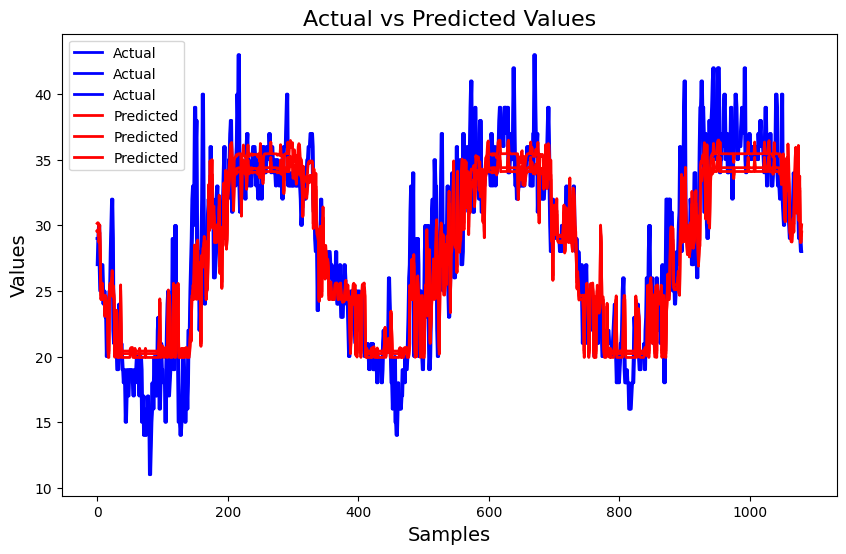

In [14]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined
plt.figure(figsize=(10, 6))

# Plot the actual values
plt.plot(y_test, label='Actual', color='blue', linewidth=2)

# Plot the predicted values
plt.plot(classical_y_pred, label='Predicted', color='red', linewidth=2)

# Adding title and labels
plt.title('Actual vs Predicted Values', fontsize=16)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Values', fontsize=14)

# Adding a legend
plt.legend()

# Display the plot
plt.show()